In [ ]:
#Importação da bibliotecas necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

#from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
url = "https://raw.githubusercontent.com/amandacmelo/Projeto-Ciencia-de-Dados/main/dados_limpos.csv"
dados = pd.read_csv(url, sep=",")

#dados = pd.read_csv(url, on_bad_lines="skip", sep=";") #lida com linhas com algum espaço vazio
dados.columns



Index(['Ano', 'CDMunicipio', 'Populacao', 'PessoalOcupado',
       'PessoalAssalariado', 'VrSalarios', 'PIB', 'QtEmpresas',
       'AreaPlantada_h', 'AreaColhida_h', 'VlProducaoAgricola',
       'VlProducaoPecuaria', 'Area', 'Importacoes_US$', 'Exportacoes_US$',
       'Receitas_R$', 'Transferencias_correntes_R$',
       'Transferencias_capital_R$', 'NrNascimentos', 'NrObitosInfantis',
       'povoamento', 'UF', 'Municipio', 'Regiao', 'PIB_PerCapita',
       'Densidade_Populacional', 'Proporcao_PessoalAssalariado',
       'Proporcao_Area_Plantada'],
      dtype='object')

# 🟤 Regressão - Municípios com maior produção agrícola tendem a ter maior área desmatada?

Na entrega anterior do trabalho, foi utilizado regras de associação (Apriori) para explorar as relações entre desmatamento e variáveis agropecuárias. As regras extraídas indicaram uma associação positiva e significativa entre esses fatores. Por exemplo:

* Quando o desmatamento e a área plantada são altos, há uma probabilidade de ~77% de que a produção agrícola também seja alta.

Esses achados sugerem que o aumento da produção agrícola e da área plantada está correlacionado com maior desmatamento, o que motivou a aplicação de uma análise de regressão nesta etapa, com o objetivo de  avaliar essa relação de forma quantitativa.

## Preparação dos dados
Nesta etapa, os dados de produção agrícola foram combinados com os dados de desmatamento por município e ano. Para isso, foi necessário padronizar os nomes das colunas de identificação e realizar a mesclagem entre os conjuntos.

Após a junção, foram selecionadas apenas as variáveis relevantes para a análise: produção agrícola, área desmatada, área plantada, área colhida e produção pecuária.


In [ ]:

url1 = "https://raw.githubusercontent.com/amandacmelo/Projeto-Ciencia-de-Dados/refs/heads/main/Dados%20sobre%20Desmatamento/area_desmatada_municipio.csv"
dados_desmatamento = pd.read_csv(url1, sep=",")

# Renomear colunas para facilitar a mesclagem
dados = dados.rename(columns={'Ano': 'ano', 'CDMunicipio': 'id_municipio'})

# Mesclar os datasets com base nas colunas 'ano' e 'id_municipio'
df = pd.merge(dados, dados_desmatamento, on=['ano', 'id_municipio'], how='inner')

# Selecionar apenas as colunas relevantes
df = df[['VlProducaoAgricola', 'desmatado', 'AreaPlantada_h', 'VlProducaoPecuaria', 'Area', 'NrNascimentos', 'QtEmpresas', 'PessoalAssalariado', 'PessoalOcupado', 'Populacao']].copy()

## 📈 Regressão Linear Simples: Área Plantada e Desmatamento
Este código aplica uma regressão linear simples para investigar se existe uma relação entre a área plantada e a área desmatada nos municípios. A ideia é verificar se, à medida que aumenta a área utilizada para plantio, também ocorre um aumento proporcional no desmatamento.

O modelo estima uma equação de reta que melhor se ajusta aos dados observados, permitindo medir a força e a direção dessa relação. Além disso, são calculadas métricas como o R², que indica o quanto da variação no desmatamento pode ser explicada pela área plantada, e o Erro Médio Absoluto (MAE), que mostra o quão próximas as previsões do modelo estão dos valores reais.

Essa abordagem ajuda a responder se áreas mais dedicadas à agricultura tendem, de fato, a apresentar maior desmatamento — e com qual intensidade.

Coeficiente estimado (β): 0.27304162419860073
Intercepto: 373.271883024796
R² (score): 0.10175792569754205
Erro Médio Absoluto (MAE): 398.76426000958423


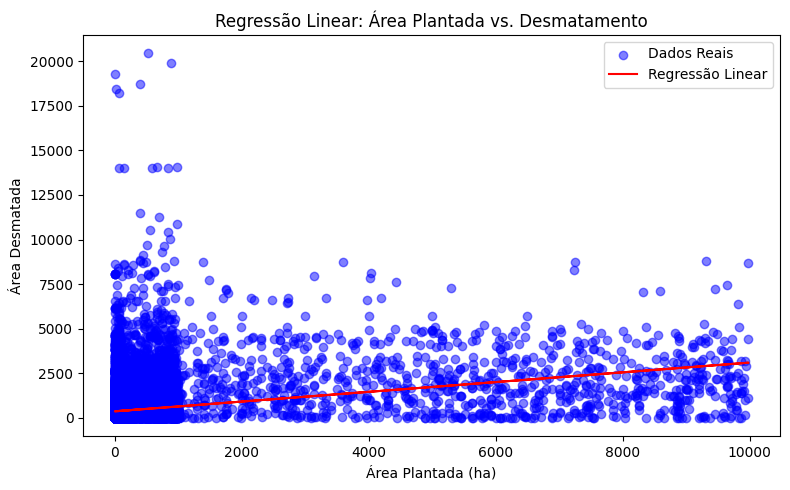

In [ ]:
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Variáveis independentes (X) e dependentes (Y)
X = df['AreaPlantada_h'].values.reshape(-1, 1)  # X deve estar em formato 2D
Y = df['desmatado'].values  # Y pode estar em formato 1D

# Criar e ajustar o modelo de regressão linear
lm = LinearRegression()
lm.fit(X, Y)

# Coeficiente (beta), intercepto e R²
print('Coeficiente estimado (β):', lm.coef_[0])
print('Intercepto:', lm.intercept_)
print('R² (score):', lm.score(X, Y))

# Previsões e Erro Médio Absoluto
Y_pred = lm.predict(X)
mae = mean_absolute_error(Y, Y_pred)
print('Erro Médio Absoluto (MAE):', mae)

# Gráfico de dispersão com linha de regressão
plt.figure(figsize=(8, 5))
plt.scatter(X, Y, color='blue', alpha=0.5, label='Dados Reais')
plt.plot(X, Y_pred, color='red', label='Regressão Linear')
plt.xlabel('Área Plantada (ha)')
plt.ylabel('Área Desmatada')
plt.title('Regressão Linear: Área Plantada vs. Desmatamento')
plt.legend()
plt.tight_layout()
plt.show()


### Conclusão
A regressão linear confirmou parcialmente a ideia de que a expansão agrícola está associada ao desmatamento. O coeficiente β = 0,273 indica uma relação positiva entre área plantada e área desmatada, alinhando-se aos achados anteriores das regras de associação.

No entanto, o R² de apenas 10,18% mostra que a área plantada explica pouco da variação no desmatamento. O erro médio absoluto de 398,76 reforça as limitações do modelo.

Assim, embora exista associação, a relação é mais complexa e depende de outros fatores não considerados, como políticas públicas, tipo de cultura e contexto regional. Modelos mais completos são necessários para entender melhor o fenômeno.

## 📈 Regressão Linear Múltipla: Váriáveis Agropecuárias e o Desmatamento

Levando em consideração a limitação levantada anteriormente, foi realizada uma regressão linear múltipla incluindo as variáveis produção agrícola e pecuária, além da área plantada e área total do município, para verificar se a adição dessas variáveis auxilia no desempenho do modelo para a explicação da variação da área desmatada.

Essa abordagem busca compreender se o desmatamento está mais fortemente relacionado ao conjunto de fatores ligados à atividade agropecuárias, em comparação ao modelo anterior, que utilizava apenas uma variável independente.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Variáveis originais
X = df[['VlProducaoAgricola', 'AreaPlantada_h', 'VlProducaoPecuaria', 'Area']]
Y = df['desmatado']

# Aplicar log1p (log(1+x)) para evitar problemas com zero
X_log = np.log1p(X)
Y_log = np.log1p(Y)

# Criar e treinar o modelo com variáveis transformadas
modelo_log = LinearRegression()
modelo_log.fit(X_log, Y_log)

# Coeficientes e intercepto
print('Coeficientes (log-transformados):')
print(pd.DataFrame(modelo_log.coef_, X.columns, columns=['Coeficiente']))
print('\nIntercepto:', modelo_log.intercept_)

# R² no espaço log-transformado
r2_log = modelo_log.score(X_log, Y_log)
print('\nR² (Score) - log transformado:', r2_log)

# Previsão no espaço log-transformado
Y_log_pred = modelo_log.predict(X_log)

# Transformar a previsão de volta para a escala original
Y_pred_original = np.expm1(Y_log_pred)

# Calcular MAE na escala original
mae_original = mean_absolute_error(Y, Y_pred_original)
print('Erro Médio Absoluto (MAE) na escala original:', mae_original)


Coeficientes (log-transformados):
                    Coeficiente
VlProducaoAgricola     0.039802
AreaPlantada_h         0.028499
VlProducaoPecuaria     0.071626
Area                   0.589673

Intercepto: 1.0692960350435552

R² (Score) - log transformado: 0.3769768954322015
Erro Médio Absoluto (MAE) na escala original: 266.85414015500555


### Conclusão
O modelo múltiplo com variáveis log-transformadas — valor da produção agrícola, área plantada, produção pecuária e área total — apresentou desempenho superior ao modelo simples, com R² de 37,7% e MAE de 266,85 na escala original. Os coeficientes positivos confirmam que diferentes dimensões da atividade agropecuária contribuem para o aumento do desmatamento, com destaque para a área total (coef. = 0.5897) e a produção pecuária.

A assimetria na distribuição dos dados justifica o uso da transformação logarítmica e indica que o desmatamento não segue uma relação puramente linear. Por isso, será adotado na próxima etapa um modelo mais robusto e não linear, como o Random Forest, capaz de capturar interações complexas entre as variáveis.

Esses resultados reforçam as conclusões obtidas nas regras de associação, confirmando a relação entre atividades agropecuárias e desmatamento. No entanto, também evidenciam que o desmatamento é um fenômeno multifatorial, que envolve outros aspectos além dos analisados.

### Visualização dos Resultados

Reforçando os achados anteriormente, os gráficos de dispersão mostram que produção agrícola, pecuária e área plantada têm relação fraca com o desmatamento (R<0,10). A área total se destaca com associação mais forte (R=0,35), indicando que a expansão territorial é o fator mais diretamente relacionado ao desmatamento. Além disso, a assimetria e dispersão dos pontos sugerem que os dados não seguem uma distribuição normal nem uma relação linear estrita, o que justifica o uso de transformações logarítmicas e modelos mais robustos nas etapas seguintes.

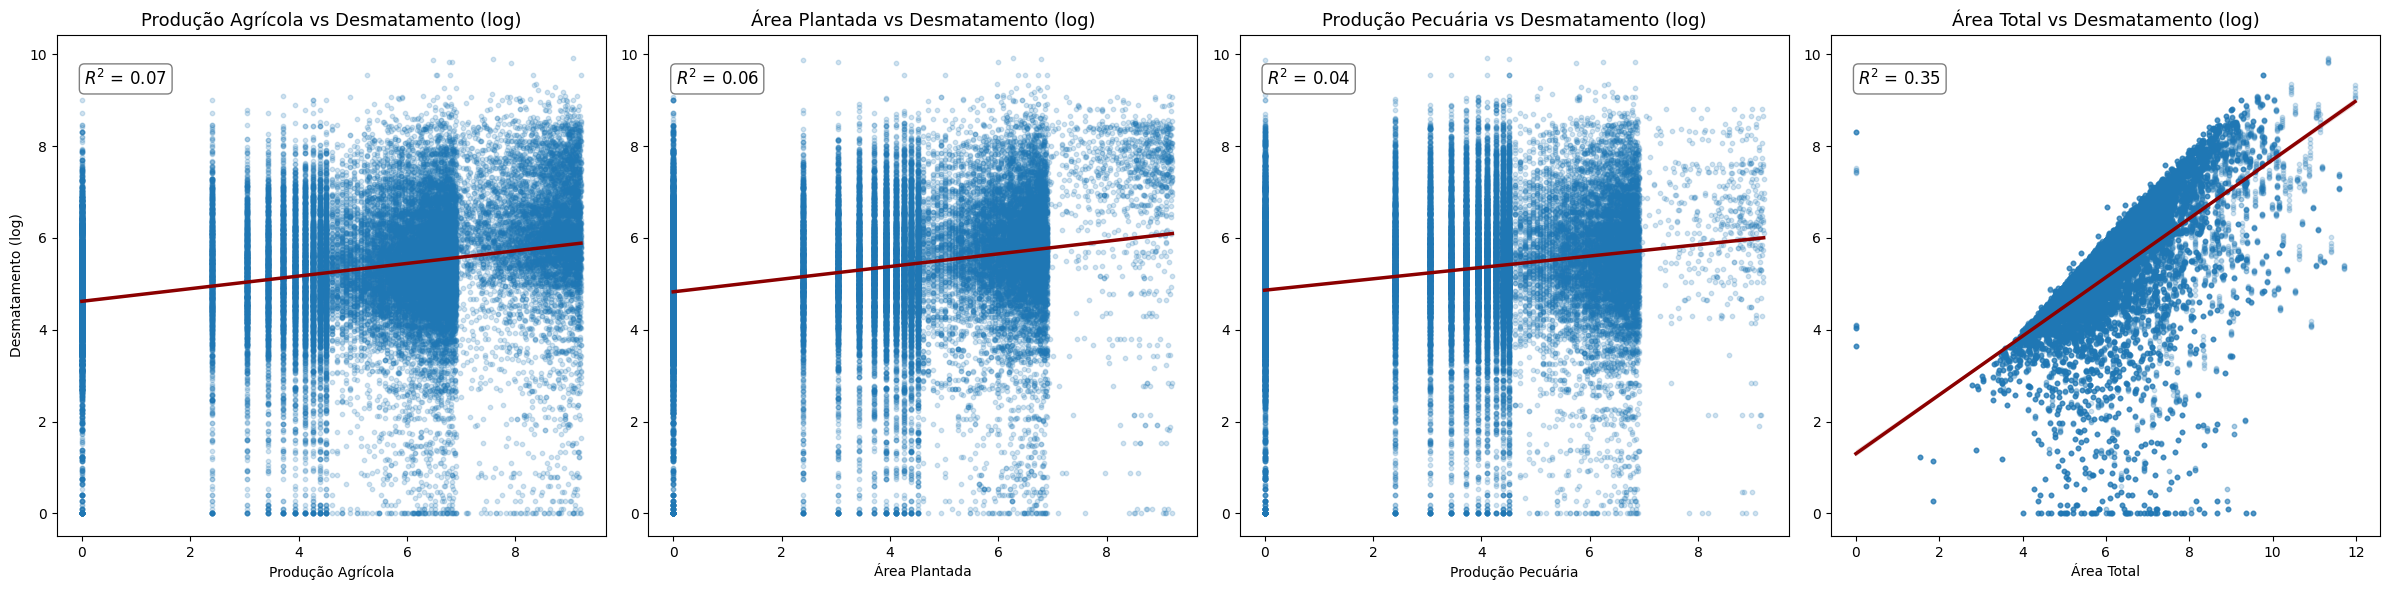

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Juntar os dados transformados para visualização
dados_plot = X_log.copy()
dados_plot['Desmatado_log'] = Y_log

# Variáveis e títulos dos gráficos
variaveis = ['VlProducaoAgricola', 'AreaPlantada_h', 'VlProducaoPecuaria', 'Area']
titulos = ['Produção Agrícola', 'Área Plantada', 'Produção Pecuária', 'Área Total']

# Criar os gráficos
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

for i, (var, titulo) in enumerate(zip(variaveis, titulos)):
    ax = axes[i]

    # Regressão com transparência nos pontos
    sns.regplot(x=var, y='Desmatado_log', data=dados_plot,
                ax=ax,
                scatter_kws={'alpha': 0.2, 's': 10},  # pontos menores e transparentes
                line_kws={'color': 'darkred', 'linewidth': 2.5})  # linha mais visível

    r, _ = pearsonr(dados_plot[var], dados_plot['Desmatado_log'])
    ax.text(0.05, 0.9, f'$R^2$ = {r**2:.2f}', transform=ax.transAxes,
            fontsize=12, bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

    ax.set_title(f'{titulo} vs Desmatamento (log)', fontsize=13)
    ax.set_xlabel(titulo)
    ax.set_ylabel('Desmatamento (log)' if i == 0 else '')

plt.tight_layout()
plt.show()
